<a href="https://colab.research.google.com/github/TongkaiYang/Vision-Zero-Madison/blob/turrkey/CS_638_weekly_plots_(10_31).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
import datetime as dt
from sklearn.cluster import DBSCAN
from IPython.display import Image
#init_notebook_mode(connected=False)
sns.set(style="white")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
raw_df = pd.read_csv('drive/My Drive/CS 638/Madison_crash_2009_2019.csv')
raw_df['ACCDDATE'] = pd.to_datetime(raw_df['ACCDDATE'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.



In [0]:
year = [x.year for x in raw_df['ACCDDATE']]
raw_df['year'] = year

In [0]:
#Intersection data
itsc = raw_df[raw_df['ACCDLOC'] == 'I'].dropna(subset = ['WISLR_LATDECDG']).reset_index(drop = True)
itsc_hwy = itsc[(itsc['HWYCLASS'] == 'U STH') | (itsc['HWYCLASS'] == 'U IH')].reset_index(drop = True)
itsc_cty = itsc[itsc['HWYCLASS'] == 'U CITY'].reset_index(drop = True)

## **Overall tendency of Accident happened in tersections**

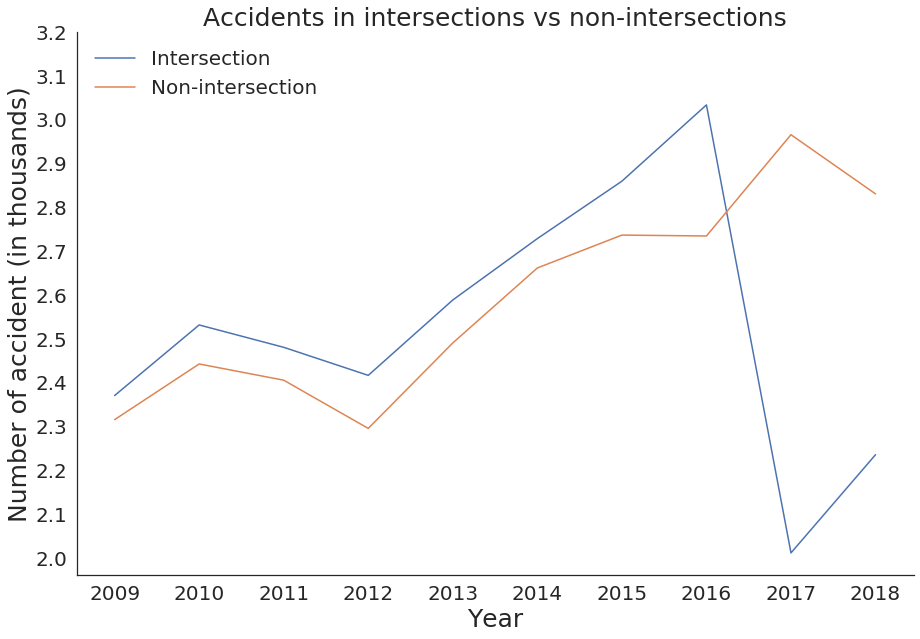

In [0]:
plt.figure(figsize = (15, 10))
itsc_nitsc = raw_df[raw_df['year'] != 2019].groupby(['year','ACCDLOC']).count()['DOCTNMBR'].reset_index()
itsc_nitsc['DOCTNMBR'] = itsc_nitsc['DOCTNMBR'] / 1000
itsc_nitsc_plt = sns.lineplot(x = 'year', y = 'DOCTNMBR', hue = 'ACCDLOC', data = itsc_nitsc)
itsc_nitsc_plt.set_xticks(range(2009, 2019, 1))
itsc_nitsc_plt.set_ylabel('Number of accident (in thousands)', fontsize = 25)
itsc_nitsc_plt.set_title('Accidents in intersections vs non-intersections', fontsize = 25)
itsc_nitsc_plt.set_xlabel('Year', fontsize = 25)
itsc_nitsc_plt.yaxis.set_ticks(np.arange(2.0, 3.2, 0.1))
itsc_nitsc_plt.tick_params(axis = 'x', labelsize = 20)
itsc_nitsc_plt.tick_params(axis = 'y', labelsize = 20)
itsc_nitsc_leg = itsc_nitsc_plt.get_legend_handles_labels()[0][1:]
itsc_nitsc_plt.legend(itsc_nitsc_leg, ['Intersection', 'Non-intersection'], title='', frameon = False, loc='upper left',fontsize = 20)
itsc_nitsc_plt.spines['right'].set_visible(False)
itsc_nitsc_plt.spines['top'].set_visible(False)

*   Before 2016, the number of accident in intersections were higher than the number of accident in non-intersection.
*   In 2016, number of accidents happened in intersections take **50%** of all accident.
*   After 2016, the ratio started to drop quickly, from 3000 (**50%**) to 2000 (**36%**).





## Apply DBSCAN clustering to highway intersection accident data to find out intersections with top number of accidents

In [0]:
#DBSCAN Clustering for highway intersection data
from sklearn.cluster import DBSCAN
def get_top5cluster(df):
  top5cluster = df.groupby(['year', 'dbcluster']).count().reset_index().sort_values(['WISLR_LATDECDG'], ascending = False).reset_index()['dbcluster'][:5].tolist()
  return top5cluster
hwy_db_df = pd.DataFrame()
cluster_rank = []
for i in range(2009, 2019, 1):
  db = DBSCAN(eps=0.0004, min_samples=10).fit(itsc_hwy[itsc_hwy['year'] == i][['WISLR_LATDECDG', 'WISLR_LONDECDG']]) #eps=0.0004 means that the radius of dbscan is 4*7.9m
  temp_df = itsc_hwy[itsc_hwy['year'] == i][['WISLR_LATDECDG', 'WISLR_LONDECDG', 'year']].copy()
  temp_df['dbcluster'] = db.labels_
  temp_df.sort_values(['dbcluster'], inplace = True)
  temp_df = temp_df[temp_df['dbcluster'] != -1]
  top5cluster = get_top5cluster(temp_df)
  hwy_db_df = pd.concat([hwy_db_df, temp_df[temp_df['dbcluster'] == top5cluster[0]], temp_df[temp_df['dbcluster'] == top5cluster[1]],
                         temp_df[temp_df['dbcluster'] == top5cluster[2]], temp_df[temp_df['dbcluster'] == top5cluster[3]],
                         temp_df[temp_df['dbcluster'] == top5cluster[4]]])
  for j in range(1, 6, 1):
    cluster_rank += [[j]*temp_df[temp_df['dbcluster'] == top5cluster[j-1]].shape[0]]

hwy_db_df['cluster_rank'] = [y for x in cluster_rank for y in x]
hwy_db_df['dbcluster'] = hwy_db_df['dbcluster'].astype(str)
hwy_db_df['cluster_rank'] = hwy_db_df['cluster_rank'].astype(str)

In [0]:
hwy_db_df.groupby(['year','cluster_rank']).count()

In [0]:
mapbox_access_token = 'pk.eyJ1IjoicnlhbnlhbmciLCJhIjoiY2swaDI5cmt0MDdpeTNkcDhwdDFmMmgwMyJ9.k-gVR4ZYPtS4YVranuGJXA'
px.set_mapbox_access_token(mapbox_access_token)
fig = px.scatter_mapbox(hwy_db_df, lat='WISLR_LATDECDG', lon='WISLR_LONDECDG', color = 'cluster_rank',
                  animation_frame = 'year', size_max=5, zoom=11, width = 1000, height = 800,
                  title = 'Location of intersection accident in Madison')
fig.show()



*   The legend show the rank of each cluster in descending order.
*   One interesting thing shown on the map is that intersections in northeastern part are always the intersections with large number of accidents. Average **23** accidents per year.
*   However, in 2013, there are 3 intersections among top 5 located in southwestern part.



## In case the map above is now showing, this is a screen shot of the map.
The bottom slide bar can be uesd to choose year.

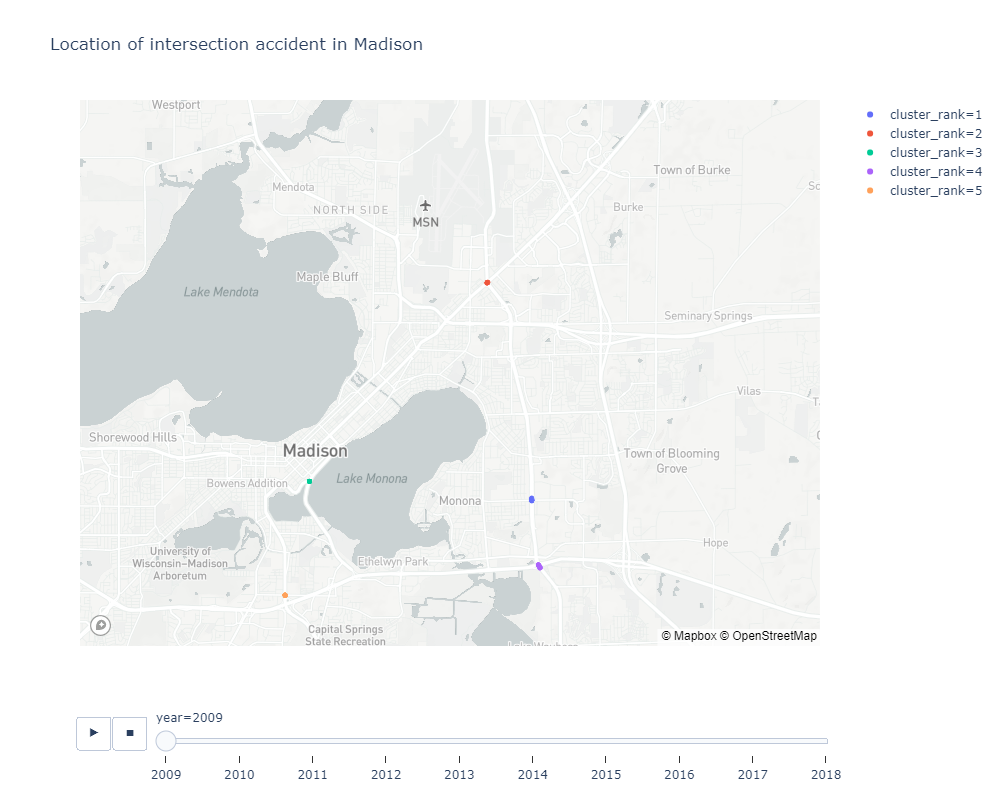

In [0]:
Image(filename='drive/My Drive/CS 638/Map.png') 